# Eartrainer C++ Core — Notebook Smoke Test
This notebook sets up import paths, imports the package, and runs a small end-to-end session.

In [15]:
# Path setup so Python can find the compiled _earcore module and the Python package
import sys, os
from pathlib import Path

def add_paths():
    cwd = Path.cwd()
    # Walk up to locate eartrainer/eartrainer_Cpp/{build,python}
    for base in [cwd, *cwd.parents]:
        build = base / 'eartrainer' / 'eartrainer_Cpp' / 'build'
        py = base / 'eartrainer' / 'eartrainer_Cpp' / 'python'
        added = False
        if build.exists():
            sys.path.insert(0, str(build))
            added = True
        if py.exists():
            sys.path.insert(0, str(py))
            added = True
        if added:
            return build, py
    return None, None

build_path, py_path = add_paths()
print('Using build path:', build_path)
print('Using python path:', py_path)


Using build path: /Users/itamarshamir/Projects/ear_trainer/eartrainer/eartrainer_Cpp/build
Using python path: /Users/itamarshamir/Projects/ear_trainer/eartrainer/eartrainer_Cpp/python


In [17]:
# Imports
from eartrainer.session_engine import SessionEngine
from eartrainer.models import SessionSpec, ResultMetrics, ResultReport, SessionSummary, TypedPayload

engine = SessionEngine()
print('Capabilities:', engine.capabilities())


Capabilities: {'assists': ['Replay', 'GuideTone', 'TempoDown', 'PathwayHint'], 'drills': ['note', 'interval', 'melody', 'chord'], 'session_assists': ['ScaleArpeggio', 'Tonic'], 'version': 'v1'}


In [11]:
import ctypes, fluidsynth; print('pyfluidsynth OK')

pyfluidsynth OK


In [18]:
# MIDI playback helper
if 'midi_player' in globals():
    try:
        midi_player.close()
    except Exception:
        pass

from eartrainer import SimpleMidiPlayer

midi_player = SimpleMidiPlayer()

def play_prompt(bundle):
    """Play the prompt for a QuestionBundle or AssistBundle."""
    prompt = getattr(bundle, 'prompt', None)
    if prompt is None:
        print('No prompt available for playback.')
        return
    midi_player.play_prompt(prompt)

def stop_audio():
    """Stop any sustained notes without tearing down the synth."""
    midi_player.stop_all()


fluidsynth: warning: SDL3 not initialized, SDL3 audio driver won't be usable. Have you called SDL_Init(SDL_INIT_AUDIO) ?


In [13]:
# Run a tiny note session end-to-end
spec = SessionSpec(
    version='v1',
    drill_kind='note',
    key='C major',
    range=[48, 72],
    tempo_bpm=90,
    n_questions=3,
    generation='adaptive',
    assistance_policy={'GuideTone': 1, 'Replay': 2},
    sampler_params={},
    seed=123,
)

session_id = engine.create_session(spec)
print('Session ID:', session_id)

results = []
while True:
    nxt = engine.next_question(session_id)
    # SessionSummary has attribute 'results'; QuestionBundle has 'question_id'
    if hasattr(nxt, 'results'):
        print('Session complete. Totals:', nxt.totals)
        break

    print('Q:', nxt.question_id, 'type:', nxt.question.type, 'payload:', nxt.question.payload)
    # Pull a guide tone assist if available
    try:
        assist = engine.assist(session_id, nxt.question_id, 'GuideTone')
        print('Assist:', assist.kind, assist.ui_delta)
    except Exception as e:
        print('Assist error:', e)

    # UI owns correctness; here we submit the provided correct answer
    metrics = ResultMetrics(rt_ms=900, attempts=1, assists_used={})
    report = ResultReport(
        question_id=nxt.question_id,
        final_answer=TypedPayload(type=nxt.correct_answer.type, payload=dict(nxt.correct_answer.payload)),
        correct=True,
        metrics=metrics,
        client_info={'source': 'notebook'},
    )
    engine.submit_result(session_id, report)


Session ID: sess-1
Q: q-001 type: note payload: {'degree': 4, 'midi': 55, 'tonic_midi': 60}
Assist: GuideTone {'message': 'Guide tone provided'}
Q: q-002 type: note payload: {'degree': 6, 'midi': 59, 'tonic_midi': 60}
Assist: GuideTone {'message': 'Guide tone provided'}
Q: q-003 type: note payload: {'degree': 2, 'midi': 64, 'tonic_midi': 60}
Assist: GuideTone {'message': 'Guide tone provided'}
Session complete. Totals: {'avg_rt_ms': 900, 'correct': 3, 'incorrect': 0}


In [14]:
# Try a chord question (single step)
spec_chord = SessionSpec(
    drill_kind='chord', n_questions=1, generation='eager', seed=42, assistance_policy={'Replay': 1}
)
sid = engine.create_session(spec_chord)
q = engine.next_question(sid)
print('Chord Q:', q.question_id, q.question.type, q.prompt.modality if q.prompt else None)
metrics = ResultMetrics(rt_ms=700, attempts=1, assists_used={})
engine.submit_result(sid, ResultReport(
    question_id=q.question_id,
    final_answer=TypedPayload(type=q.correct_answer.type, payload=dict(q.correct_answer.payload)),
    correct=True, metrics=metrics, client_info={}))
print('Chord summary:', engine.next_question(sid).totals)


Chord Q: q-001 chord midi-clip
Chord summary: {'avg_rt_ms': 700, 'correct': 1, 'incorrect': 0}


In [15]:
# Helpers and note sampling utilities
NOTE_NAMES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

def midi_to_name(midi: int) -> str:
    note = NOTE_NAMES[midi % 12]
    octave = midi // 12 - 1
    return f"{note}{octave}"

def wrap_scale_degree(degree: int) -> int:
    idx = degree % 7
    if idx < 0:
        idx += 7
    return idx + 1

def sample_note_questions(key: str = 'C major', n: int = 20, seed: int = 101):
    spec = SessionSpec(
        drill_kind='note',
        key=key,
        n_questions=n,
        generation='eager',
        assistance_policy={},
        seed=seed,
    )
    session_id = engine.create_session(spec)
    rows = []
    for _ in range(n):
        bundle = engine.next_question(session_id)
        if isinstance(bundle, SessionSummary):
            break
        raw = bundle.question.payload
        rows.append({
            'question_id': bundle.question_id,
            'raw': raw,
            'degree_raw': raw['degree'],
            'note_name': midi_to_name(raw['midi']),
        })
        metrics = ResultMetrics(rt_ms=600, attempts=1, assists_used={})
        report = ResultReport(
            question_id=bundle.question_id,
            final_answer=bundle.correct_answer,
            correct=True,
            metrics=metrics,
            client_info={'source': 'notebook-note-sample'},
        )
        engine.submit_result(session_id, report)
    return rows

note_key = 'B major'
note_seed = 101
note_samples = sample_note_questions(key=note_key, n=20, seed=note_seed)
print(f'Key: {note_key} (seed={note_seed})')
for item in note_samples:
    print(f"{item['question_id']}: degree {item['degree_raw']} (raw={item['degree_raw']}) -> {item['note_name']} | payload={item['raw']}")



Key: B major (seed=101)
q-001: degree 4 (raw=4) -> F#4 | payload={'degree': 4, 'midi': 66, 'tonic_midi': 59}
q-002: degree 1 (raw=1) -> C#4 | payload={'degree': 1, 'midi': 61, 'tonic_midi': 59}
q-003: degree 0 (raw=0) -> B4 | payload={'degree': 0, 'midi': 71, 'tonic_midi': 59}
q-004: degree 3 (raw=3) -> E3 | payload={'degree': 3, 'midi': 52, 'tonic_midi': 59}
q-005: degree 4 (raw=4) -> F#3 | payload={'degree': 4, 'midi': 54, 'tonic_midi': 59}
q-006: degree 3 (raw=3) -> E4 | payload={'degree': 3, 'midi': 64, 'tonic_midi': 59}
q-007: degree 5 (raw=5) -> G#4 | payload={'degree': 5, 'midi': 68, 'tonic_midi': 59}
q-008: degree 6 (raw=6) -> A#3 | payload={'degree': 6, 'midi': 58, 'tonic_midi': 59}
q-009: degree 1 (raw=1) -> C#3 | payload={'degree': 1, 'midi': 49, 'tonic_midi': 59}
q-010: degree 0 (raw=0) -> B3 | payload={'degree': 0, 'midi': 59, 'tonic_midi': 59}
q-011: degree 2 (raw=2) -> D#4 | payload={'degree': 2, 'midi': 63, 'tonic_midi': 59}
q-012: degree 6 (raw=6) -> A#3 | payload={'de

In [17]:
import time
# Chord sampling preview
def sample_chord_questions(key: str = 'C major', n: int = 60, seed: int = 202):
    spec = SessionSpec(
        drill_kind='chord',
        key=key,
        n_questions=n,
        generation='eager',
        assistance_policy={},
        seed=seed,
    )
    session_id = engine.create_session(spec)
    rows = []
    prompts = []
    for _ in range(n):
        bundle = engine.next_question(session_id)
        prompts.append(bundle)
        if isinstance(bundle, SessionSummary):
            break
        raw = bundle.question.payload
        voicing_names = [midi_to_name(m) for m in raw['voicing_midi']]
        rows.append({
            'question_id': bundle.question_id,
            'degree': wrap_scale_degree(raw['root_degree']),
            'quality': raw.get('quality'),
            'voicing': voicing_names,
            'raw': raw,
        })
        metrics = ResultMetrics(rt_ms=600, attempts=1, assists_used={})
        report = ResultReport(
            question_id=bundle.question_id,
            final_answer=bundle.correct_answer,
            correct=True,
            metrics=metrics,
            client_info={'source': 'notebook-chord-sample'},
        )
        engine.submit_result(session_id, report)
    return rows, prompts

chord_key = 'C major'
chord_seed = 202
chord_samples, prompts = sample_chord_questions(key=chord_key, n=60, seed=chord_seed)
print(f'Key: {chord_key} (seed={chord_seed})')
for item in chord_samples:
    voicing_str = ', '.join(item['voicing'])
    if item['degree'] == 7:
        print(f"{item['question_id']}: degree {item['degree']} ({item['quality']}) -> {voicing_str}")
    #print(f"    raw={item['raw']}")

for p in prompts[1:4]:
    play_prompt(p)
    time.sleep(0.5)



Key: C major (seed=202)
q-001: degree 7 (diminished) -> B1, F3, B3, D4
q-008: degree 7 (diminished) -> B1, B3, D4, F4
q-014: degree 7 (diminished) -> B1, B3, D4, F4, B4
q-016: degree 7 (diminished) -> B1, B3, D4, F4, B4
q-021: degree 7 (diminished) -> B1, B3, D4, F4
q-025: degree 7 (diminished) -> B1, F3, B3, D4
q-039: degree 7 (diminished) -> B1, B3, D4, F4
q-041: degree 7 (diminished) -> B1, F3, B3, D4
q-049: degree 7 (diminished) -> B1, B3, D4, F4


In [18]:
import time
# Interval sampling preview
def sample_interval_questions(key: str = 'C major', n: int = 20, seed: int = 303):
    spec = SessionSpec(
        drill_kind='interval',
        key=key,
        n_questions=n,
        generation='eager',
        assistance_policy={},
        seed=seed,
    )
    session_id = engine.create_session(spec)
    rows = []
    prompts = []
    for _ in range(n):
        bundle = engine.next_question(session_id)
        prompts.append(bundle)
        if isinstance(bundle, SessionSummary):
            break
        payload = bundle.question.payload
        bottom_name = midi_to_name(payload['bottom_midi'])
        top_name = midi_to_name(payload['top_midi'])
        rows.append({
            'question_id': bundle.question_id,
            'bottom_deg': payload['bottom_degree'],
            'top_deg': payload['top_degree'],
            'bottom_midi': bottom_name,
            'top_midi': top_name,
            'raw': payload,
            'answer': bundle.correct_answer.payload,
        })
        metrics = ResultMetrics(rt_ms=650, attempts=1, assists_used={})
        report = ResultReport(
            question_id=bundle.question_id,
            final_answer=bundle.correct_answer,
            correct=True,
            metrics=metrics,
            client_info={'source': 'notebook-interval-sample'},
        )
        engine.submit_result(session_id, report)
    return rows, prompts

interval_key = 'C major'
interval_seed = 303
interval_samples, prompts = sample_interval_questions(key=interval_key, n=20, seed=interval_seed)
print(f'Key: {interval_key} (seed={interval_seed})')
for item in interval_samples:
    bottom = item['bottom_midi']
    top = item['top_midi']
    answer = item['answer']
    answer_name = answer.get('name') if isinstance(answer, dict) else answer
    print(f"{item['question_id']}: bottom deg {item['bottom_deg']} -> {bottom}, top deg {item['top_deg']} -> {top} | interval {answer_name} | raw={item['raw']}")

for p in prompts[:3]:
    play_prompt(p)
    time.sleep(1)

stop_audio()


Key: C major (seed=303)
q-001: bottom deg 6 -> B4, top deg 12 -> A5 | interval m7 | raw={'bottom_degree': 6, 'bottom_midi': 71, 'orientation': 'ascending', 'top_degree': 12, 'top_midi': 81}
q-002: bottom deg 0 -> C4, top deg 4 -> G4 | interval P5 | raw={'bottom_degree': 0, 'bottom_midi': 60, 'orientation': 'ascending', 'top_degree': 4, 'top_midi': 67}
q-003: bottom deg 3 -> F3, top deg 4 -> G3 | interval M2 | raw={'bottom_degree': 3, 'bottom_midi': 53, 'orientation': 'descending', 'top_degree': 4, 'top_midi': 55}
q-004: bottom deg 2 -> E3, top deg 3 -> F3 | interval m2 | raw={'bottom_degree': 2, 'bottom_midi': 52, 'orientation': 'descending', 'top_degree': 3, 'top_midi': 53}
q-005: bottom deg 5 -> A4, top deg 12 -> A5 | interval P1 | raw={'bottom_degree': 5, 'bottom_midi': 69, 'orientation': 'descending', 'top_degree': 12, 'top_midi': 81}
q-006: bottom deg 3 -> F4, top deg 9 -> E5 | interval M7 | raw={'bottom_degree': 3, 'bottom_midi': 65, 'orientation': 'ascending', 'top_degree': 9, '

In [20]:
# Generate 20 note questions with pathways enabled and print prompt notes
from eartrainer.session_engine import SessionEngine
from eartrainer.models import SessionSpec
import time

engine = SessionEngine()
spec = SessionSpec(
    drill_kind='note',
    key='C major',
    tempo_bpm=110,
    n_questions=20,
    generation='eager',
    assistance_policy={'Replay': 1},
    sampler_params={
        'use_pathway': True,
        'pathway_tempo_bpm': 90,    # pathway tempo; falls back to tempo_bpm if omitted
        'pathway_step_beats': 1.0,  # quarter notes
        'pathway_rest_beats': 1.5,  # eighth-note rest before resolution
        'pathway_repeat_lead': True,
    },
    seed=2025,
)

sid = engine.create_session(spec)
prompts = []
rows = []
for _ in range(spec.n_questions):
    q = engine.next_question(sid)
    prompts.append(q)
    if q.prompt is None:
        continue
    clip = q.prompt.midi_clip if q.prompt else None
    # Summarize first track events as (t, type, note)
    if clip and clip.tracks:
        evs = [(ev.t, ev.type, ev.note) for ev in clip.tracks[0].events[:8]]
    else:
        evs = []
    rows.append((q.question_id, q.question.payload, evs))
    fake = ResultReport(
        question_id=q.question_id,
        final_answer=TypedPayload(type=q.correct_answer.type, payload={'degree': q.correct_answer.payload['degree']}),
        correct=True,
        metrics=ResultMetrics(rt_ms=0, attempts=1)
    )
    engine.submit_result(sid, fake)

# Pretty print first few prompts; full data is in 'rows'
for row in rows:
    print(row[0], 'payload=', row[1], 'notes=', row[2])

for p in prompts[:2]:
    play_prompt(p)
    print(p.prompt.midi_clip)
    time.sleep(1)

stop_audio()

len(rows)


q-001 payload= {'degree': 4, 'midi': 67, 'tonic_midi': 60} notes= [(0, 'note_on', 67), (480, 'note_off', 67), (1200, 'note_on', 67), (1680, 'note_off', 67), (1680, 'note_on', 69), (2160, 'note_off', 69), (2160, 'note_on', 71), (2640, 'note_off', 71)]
q-002 payload= {'degree': 5, 'midi': 69, 'tonic_midi': 60} notes= [(0, 'note_on', 69), (480, 'note_off', 69), (1200, 'note_on', 69), (1680, 'note_off', 69), (1680, 'note_on', 71), (2160, 'note_off', 71), (2160, 'note_on', 72), (2640, 'note_off', 72)]
q-003 payload= {'degree': 6, 'midi': 71, 'tonic_midi': 60} notes= [(0, 'note_on', 71), (480, 'note_off', 71), (1200, 'note_on', 71), (1680, 'note_off', 71), (1680, 'note_on', 72), (2160, 'note_off', 72)]
q-004 payload= {'degree': 0, 'midi': 60, 'tonic_midi': 60} notes= [(0, 'note_on', 60), (480, 'note_off', 60), (1200, 'note_on', 60), (1680, 'note_off', 60)]
q-005 payload= {'degree': 5, 'midi': 69, 'tonic_midi': 60} notes= [(0, 'note_on', 69), (480, 'note_off', 69), (1200, 'note_on', 69), (168

20

# Fitness

## Normalized meausres

$N_n = \frac{(N-1)}{(N_{max}-1)}$, 

$t_n = \frac{(t - t_{min})}{(t_{max} - t_{min})}$, 

$T_n =  1- \frac{1}{2}\frac{(T - T_{min})}{(T_{max} - T_{min})}$

## Singl note fitness
Normalization mean reaction time for single note
$$ T_* = 1- \frac{1}{2}\frac{(\bar{T} - T_0)}{(T_1 - T_0)} $$

## Expected Fitness
<!-- $$
F_e(N, t, T) = p^* \left( \omega N_n t_n + (1 - \omega) \,\rm{Clip}_{0,1}\left(T_n \right) \right)
$$ -->

$$
F_e(N, t, T) = p^* \left( \omega \frac{(N-1)}{(N_1-1)} \times \frac{(t - t_0)}{(t_1 - t_0)} + (1 - \omega) \,\rm{Clip}_{0,1}\left( 1- \frac{1}{2}\frac{(T - T_0)}{(T_1 - T_0)}\right) \right)
$$

## Response time prediction

$$
T_n = \frac{1}{(1- \omega)} \left(F - \omega N_n t_n \right)
$$



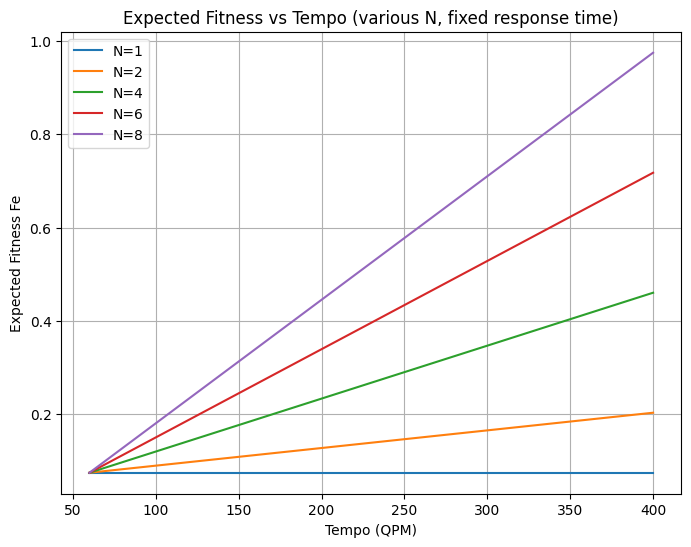

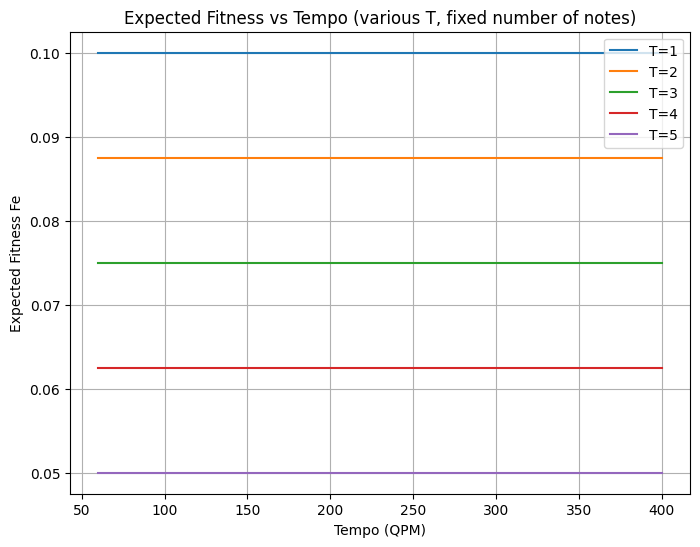

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters (from the simplified model)
N_max = 8
tempo_min, tempo_max = 60, 400   # tempo range (quarter notes per minute)
wN = 0.9
p_star = 1 # 0.85
Tmin = 1
Tmax = 5

def q_difficulty(N, N_max, tempo, t_min, t_max, wN):
    n = (N - 1) / (N_max - 1)
    t = (tempo - t_min) / (t_max - t_min)
    return n * t
    # return np.clip(wN * n + (1.0 - wN) * t, 0.0, 1.0)

def response_time(T):
    return np.clip(- 0.5 * (T - Tmin) / (Tmax - Tmin) + 1, 0, 1)

def expected_item(N, tempo, T, N_max, t_min, t_max, wN, p_star):
    q = q_difficulty(N, N_max, tempo, t_min, t_max, wN)
    Tr = response_time(T)
    return p_star * (wN * q + (1 - wN) * Tr)

def expected_item2(N, tempo, T, N_max, t_min, t_max, wN, p_star):
    n = (N - 1) / (N_max - 1)
    t = (tempo - t_min) / (t_max - t_min)
    Tr = response_time(T)
    return p_star * (n + 1) * (wN * t + (1 - wN) * Tr)

# Plot expected fitness vs tempo for various N
tempos = np.linspace(tempo_min, tempo_max, 200)
T0 = 3  # fixed response time for this plot

plt.figure(figsize=(8,6))

for N in [1, 2, 4, 6, 8]:
    Fe_values = [expected_item(N, tempo, T0, N_max, tempo_min, tempo_max, wN, p_star) for tempo in tempos]
    plt.plot(tempos, Fe_values, label=f"N={N}")

plt.title("Expected Fitness vs Tempo (various N, fixed response time)")
plt.xlabel("Tempo (QPM)")
plt.ylabel("Expected Fitness Fe")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))

N0 = 1
for T in [1, 2, 3, 4, 5]:
    Fe_values = [expected_item(N0, tempo, T, N_max, tempo_min, tempo_max, wN, p_star) for tempo in tempos]
    plt.plot(tempos, Fe_values, label=f"T={T}")

plt.title("Expected Fitness vs Tempo (various T, fixed number of notes)")
plt.xlabel("Tempo (QPM)")
plt.ylabel("Expected Fitness Fe")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
F = 0.09
for N in [1, 2, 4, 6, 8]:
    print(f"N={N}:")
    for T in [1, 2, 3, 4, 5]:
        for t in [60, 100, 150, 200, 250, 300, 350, 400]:
            Fe = expected_item(N, t, T, N_max, tempo_min, tempo_max, wN, p_star)
            # print(f"N={N}, T={T} => Fe={Fe:.3f}")
            if Fe >= F:
                print(f"T={T}, t={t} => Fe={Fe:.3f} >= {F}")
                break

N=1:
T=1, t=60 => Fe=0.100 >= 0.09
N=2:
T=1, t=60 => Fe=0.100 >= 0.09
T=2, t=100 => Fe=0.103 >= 0.09
T=3, t=100 => Fe=0.090 >= 0.09
T=4, t=150 => Fe=0.097 >= 0.09
T=5, t=200 => Fe=0.103 >= 0.09
N=4:
T=1, t=60 => Fe=0.100 >= 0.09
T=2, t=100 => Fe=0.133 >= 0.09
T=3, t=100 => Fe=0.120 >= 0.09
T=4, t=100 => Fe=0.108 >= 0.09
T=5, t=100 => Fe=0.095 >= 0.09
N=6:
T=1, t=60 => Fe=0.100 >= 0.09
T=2, t=100 => Fe=0.163 >= 0.09
T=3, t=100 => Fe=0.151 >= 0.09
T=4, t=100 => Fe=0.138 >= 0.09
T=5, t=100 => Fe=0.126 >= 0.09
N=8:
T=1, t=60 => Fe=0.100 >= 0.09
T=2, t=100 => Fe=0.193 >= 0.09
T=3, t=100 => Fe=0.181 >= 0.09
T=4, t=100 => Fe=0.168 >= 0.09
T=5, t=100 => Fe=0.156 >= 0.09


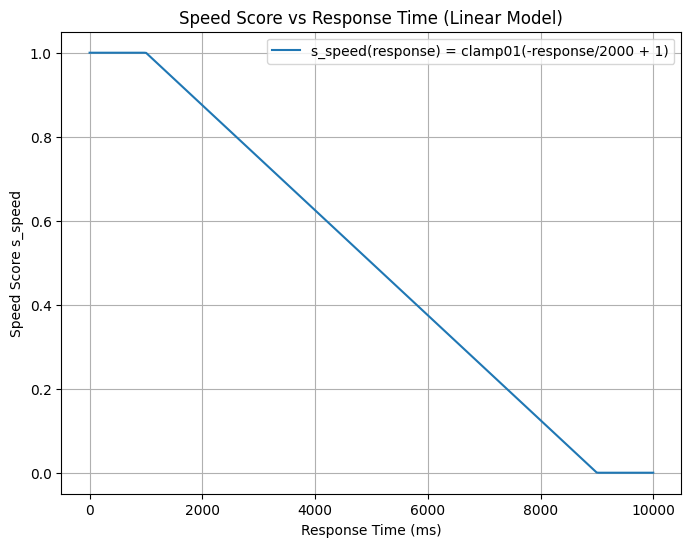

In [ ]:
# plot s_speed(response) = clamp01( - response/T0 + beta) as function of response time
Tmax = 5000  # time constant in ms
Tmin = 1000
beta = 1  # offset
responses = np.linspace(0, 10000, 300)
s_speed_linear = np.clip(- 0.5 * (responses - Tmin) / (Tmax - Tmin) + 1, 0, 1.0)
plt.figure(figsize=(8,6))
plt.plot(responses, s_speed_linear, label=f"s_speed(response) = clamp01(-response/{T0} + {beta})")
plt.title("Speed Score vs Response Time (Linear Model)")
plt.xlabel("Response Time (ms)")
plt.ylabel("Speed Score s_speed")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
import _earcore

engine = _earcore.SessionEngine()

adaptive_spec = {
    "version": "v1",
    "drill_kind": "melody",
    "key": "C major",
    "range": [48, 72],
    "tempo_bpm": 100,
    "n_questions": 100,
    "generation": "adaptive",
    "assistance_policy": {"Replay": 2},
    "sampler_params": {
        "drills": ["melody", "note"],
        "weights": {"melody": 1.0, "note": 1.0},
        "initial_fitness": 0.5
    },
    "seed": 2024,
    "adaptive": True
}

session_id = engine.create_session(adaptive_spec)
counts = {}

for _ in range(adaptive_spec["n_questions"]):
    bundle = engine.next_question(session_id)
    kind = bundle["question"]["type"]
    counts[kind] = counts.get(kind, 0) + 1
    report = {
        "question_id": bundle["question_id"],
        "final_answer": bundle["correct_answer"],
        "correct": True,
        "metrics": {
            "rt_ms": 1200,
            "attempts": 1,
            "assists_used": {},
            "first_input_rt_ms": 900
        }
    }
    engine.submit_result(session_id, report)

counts, engine.debug_state(session_id)

({'melody': 49, 'note': 51},
 {'adaptive_asked': 100,
  'adaptive_fitness': 0.5,
  'adaptive_target': 100,
  'drill_counts': {'melody': 49, 'note': 51},
  'drill_hub': {'entries': [{'cumulative': 1.0,
     'drill_kind': 'melody',
     'weight': 1.0},
    {'cumulative': 2.0, 'drill_kind': 'note', 'weight': 1.0}],
   'last_selected': 'melody',
   'size': 2,
   'total_weight': 2.0},
  'mode': 'adaptive',
  'result_count': 100,
  'session_id': 'sess-1',
  'summary_ready': True})

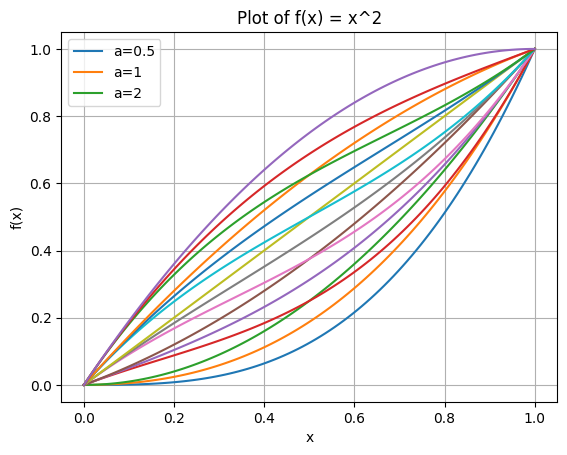

In [72]:
# plot f(x) = x^2 between 0 and 1
import numpy as np  
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 100)
for a in [-1, -0.5, 0, 0.5, 1]:
    for b in [-1, -0.5, 0]:
        y = x + x * (1 - x) * (a + b * x)
        plt.plot(x, y)
plt.title("Plot of f(x) = x^2")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend([f"a={a}" for a in [0.5, 1, 2]])
plt.show()  

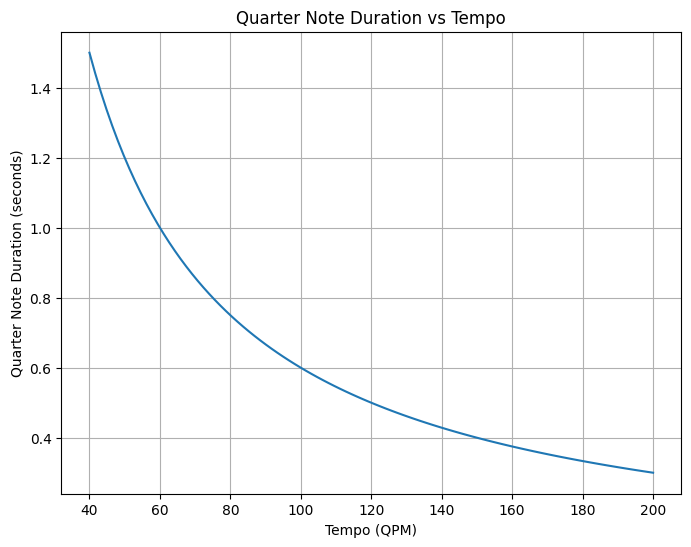

In [3]:
# 60 BPM, quarter note = 1 second per beat
# 90 BPM, quarter note = 0.67 seconds per beat
import numpy as np
import matplotlib.pyplot as plt

# quarter_note_duration
# plot quarter_note_duration vs tempo
tempos = np.linspace(40, 200, 100)
durations = 60 / tempos
plt.figure(figsize=(8,6))
plt.plot(tempos, durations)
plt.title("Quarter Note Duration vs Tempo")     
plt.xlabel("Tempo (QPM)")
plt.ylabel("Quarter Note Duration (seconds)")
plt.grid(True)
plt.show()

In [14]:
BPM = 60
f = 1.2
for i in range(15):
    print(f"{i}) BPM = {BPM * (f)**i:.1f} -> quarter note duration = {60 / (BPM * (f)**i):.2f} seconds")

0) BPM = 60.0 -> quarter note duration = 1.00 seconds
1) BPM = 72.0 -> quarter note duration = 0.83 seconds
2) BPM = 86.4 -> quarter note duration = 0.69 seconds
3) BPM = 103.7 -> quarter note duration = 0.58 seconds
4) BPM = 124.4 -> quarter note duration = 0.48 seconds
5) BPM = 149.3 -> quarter note duration = 0.40 seconds
6) BPM = 179.2 -> quarter note duration = 0.33 seconds
7) BPM = 215.0 -> quarter note duration = 0.28 seconds
8) BPM = 258.0 -> quarter note duration = 0.23 seconds
9) BPM = 309.6 -> quarter note duration = 0.19 seconds
10) BPM = 371.5 -> quarter note duration = 0.16 seconds
11) BPM = 445.8 -> quarter note duration = 0.13 seconds
12) BPM = 535.0 -> quarter note duration = 0.11 seconds
13) BPM = 642.0 -> quarter note duration = 0.09 seconds
14) BPM = 770.4 -> quarter note duration = 0.08 seconds


In [13]:
BPM = 60
d = 20 
for i in range(15):
    print(f"{i}) BPM = {BPM + d*i} -> quarter note duration = {60 / (BPM + d * i)} seconds")

0) BPM = 60 -> quarter note duration = 1.0 seconds
1) BPM = 80 -> quarter note duration = 0.75 seconds
2) BPM = 100 -> quarter note duration = 0.6 seconds
3) BPM = 120 -> quarter note duration = 0.5 seconds
4) BPM = 140 -> quarter note duration = 0.42857142857142855 seconds
5) BPM = 160 -> quarter note duration = 0.375 seconds
6) BPM = 180 -> quarter note duration = 0.3333333333333333 seconds
7) BPM = 200 -> quarter note duration = 0.3 seconds
8) BPM = 220 -> quarter note duration = 0.2727272727272727 seconds
9) BPM = 240 -> quarter note duration = 0.25 seconds
10) BPM = 260 -> quarter note duration = 0.23076923076923078 seconds
11) BPM = 280 -> quarter note duration = 0.21428571428571427 seconds
12) BPM = 300 -> quarter note duration = 0.2 seconds
13) BPM = 320 -> quarter note duration = 0.1875 seconds
14) BPM = 340 -> quarter note duration = 0.17647058823529413 seconds


In [ ]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Optional, Iterable
import math
import random

# -----------------------------
# Constants & helpers
# -----------------------------

T_MIN_SEC = 1.0   # hard full-credit boundary
T_MAX_SEC = 9.0   # hard zero-credit boundary

# Normalization helpers (tempo and N are normalized elsewhere if needed)
def clip01(x: float) -> float:
    return max(0.0, min(1.0, x))

def norm_tempo(t: int, t_min: int, t_max: int) -> float:
    return clip01((t - t_min) / (t_max - t_min))

# Convert raw response seconds to normalized speed credit in [0,1]
# 1s -> 1.0 ; 9s -> 0.0 ; linear in between (you can swap to a curve if desired)
def speed_credit_from_seconds(sec: float) -> float:
    if sec <= T_MIN_SEC:
        return 1.0
    if sec >= T_MAX_SEC:
        return 0.0
    # linear map: (1 -> 1) to (9 -> 0)
    return 1.0 - (sec - T_MIN_SEC) / (T_MAX_SEC - T_MIN_SEC)

# Inverse (approx) for convenience if needed later

def seconds_from_speed_credit(credit: float) -> float:
    credit = clip01(credit)
    return T_MIN_SEC + (1.0 - credit) * (T_MAX_SEC - T_MIN_SEC)

# -----------------------------
# Drill menu, sampler, and scoring
# -----------------------------

@dataclass
class DrillCandidate:
    N: int           # number of notes
    tempo: int       # bpm
    pred_sec: float  # predicted response seconds per note
    Fe: float        # expected fitness according to current model
    q: float         # difficulty measure
    def __str__(self):
        return f"DrillCandidate(N={self.N}, tempo={self.tempo}, pred_sec={self.pred_sec:.2f}, Fe={self.Fe:.3f}, q={self.q:.3f})"
    def __repr__(self):
        return self.__str__()

# --- Sampler pluggable policy ---
class Sampler:
    """Strategy interface for choosing the next candidate from a fixed bout menu."""
    def pick(self, menu: List[DrillCandidate], last: Optional[DrillCandidate]) -> DrillCandidate:
        raise NotImplementedError

class UniformSampler(Sampler):
    """Uniform random selection over the fixed bout menu.
    Keeps API flexible so we can swap policies later without touching DrillHub.
    """
    def pick(self, menu: List[DrillCandidate], last: Optional[DrillCandidate]) -> DrillCandidate:
        if not menu:
            raise ValueError("Empty menu: cannot sample")
        return random.choice(menu)
      

@dataclass
class BoutStats:
    n_items: int = 0
    sum_score: float = 0.0
    @property
    def avg_score(self) -> float:
        return self.sum_score / self.n_items if self.n_items > 0 else 0.0

class DrillHub:
    """Bout-level adaptive melodic hub (single-note, intervals, melodies>=3).

    SIMPLE VERSION:
    - Menu is chosen once at new_bout(F, tempos, ...), kept fixed during the bout.
    - Sampling is delegated to a pluggable Sampler (default: UniformSampler).
    - No tempo calibration: feedback does not update any calibrator; we use a
      fixed per-bout target response time (seconds per note) for expectations.
    - Fitness is NOT changed mid-bout in this simple version.
 

    API:
      dh = DrillHub(F=0.5, p_star=0.85, tempos=[72,84,96], N_set=[1,2,3,4])
      dh.new_bout(F)    # optional: reseed with external fitness
      cand = dh.next()  # -> DrillCandidate
      dh.feedback(correct=True, observed_sec=1.4)
      ... (repeat) ...
      stats = dh.update()  # end-of-bout summary
    """
    def __init__(self,
                 F: float,
                 p_star: float = 0.85,
                 wN: float = 0.9,
                 tempos: Optional[List[int]] = None,
                 N_set: Optional[List[int]] = None,
                 tempo_min: int = 60,
                 tempo_max: int = 400,
                 N_max: int = 8,
                 sampler: Optional[Sampler] = None,
                 target_sec: float = 1.5):
        self.F = float(F)
        self.p_star = float(p_star)
        self.wN = float(wN)
        self.tempo_min = int(tempo_min)
        self.tempo_max = int(tempo_max)
        self.N_max = int(N_max)
        self.N_set = N_set or [1, 2, 3, 4, 5, 6, 7, 8]
        # limit active tempos per bout; persistent calibrators handle full range
        self.active_tempos = tempos or [60, 90, 120, 150, 180, 210, 240, 270]#[72, 84, 96]
        # No calibrator in the simple version; use a fixed per-bout expected seconds per note.
        self.target_sec = float(target_sec)
        self._last_candidate: Optional[DrillCandidate] = None
        self._bout = BoutStats()
        # hysteresis settings
        self.max_bpm_step = 8
        self.allow_N_step = 1
        self._last_N = None
        self._last_tempo = None
        # fixed bout menu
        self.menu: List[DrillCandidate] = []
        # pluggable sampler (default: uniform)
        self.sampler: Sampler = sampler or UniformSampler()

    # -----------------
    # Public API
    # -----------------
    def new_bout(self, F: Optional[float] = None, tempos: Optional[List[int]] = None):
        if F is not None:
            self.F = float(F)
        if tempos is not None:
            self.active_tempos = list(tempos)
        self._bout = BoutStats()
        self._last_candidate = None
        self._last_N = None
        self._last_tempo = None
        # build and freeze the bout menu once
        self.menu = self._make_menu()
        print(f"Menu items: {len(self.menu)}")
        for item in self.menu:
            print(f"  {item}")

    def next(self) -> DrillCandidate:
        if not self.menu:
            # if new_bout was not called, build a default menu now
            self.menu = self._make_menu()
        cand = self.sampler.pick(self.menu, self._last_candidate)
        self._last_candidate = cand
        self._last_N = cand.N
        self._last_tempo = cand.tempo
        return cand

    def feedback(self, correct: bool, observed_sec: float):
        if self._last_candidate is None:
            return
        # score this item (no calibration updates in simple version)
        T_clip = speed_credit_from_seconds(observed_sec)
        per_item_score = (1.0 if correct else 0.0) * T_clip
        self._bout.n_items += 1
        self._bout.sum_score += per_item_score

    def update(self) -> BoutStats:
        # End-of-bout hook (smoothing happens lazily on predict)
        return self._bout

    # -----------------
    # Internals
    # -----------------
    def _q_difficulty(self, N: int, tempo: int) -> float:
        # normalized N and tempo
        n = (N - 1) / (self.N_max - 1) if self.N_max > 1 else 0.0
        t = norm_tempo(tempo, self.tempo_min, self.tempo_max)
        return clip01(n * t)

    def _expected_fitness(self, N: int, tempo: int) -> Tuple[float, float]:
        # Simple version: expected response seconds is a fixed per-bout target
        pred_sec = self.target_sec
        T_clip = speed_credit_from_seconds(pred_sec)
        q = self._q_difficulty(N, tempo)
        Fe = self.p_star * (self.wN * q + (1.0 - self.wN) * T_clip)
        return max(0.0, min(1.0, Fe)), q

    def _make_menu(self) -> List[DrillCandidate]:
        """Build full bout menu from current settings. No per-item rate limits.
        Filters by feasibility and keeps ALL feasible items; sampling is uniform.
        """
        menu: List[DrillCandidate] = []
        for N in self.N_set:
            if N == 1:
                # Beginner single-note pathway/drone can be modeled as a fixed slow tempo.
                tempo = 60
                pred_sec = self.target_sec
                if T_MIN_SEC <= pred_sec <= T_MAX_SEC:
                    Fe, q = self._expected_fitness(1, tempo)
                    menu.append(DrillCandidate(N=1, tempo=tempo, pred_sec=pred_sec, Fe=Fe, q=q))
                continue
            for tempo in self.active_tempos:
                pred_sec = self.target_sec
                if pred_sec < T_MIN_SEC or pred_sec > T_MAX_SEC:
                    continue
                Fe, q = self._expected_fitness(N, tempo)
                menu.append(DrillCandidate(N=N, tempo=tempo, pred_sec=pred_sec, Fe=Fe, q=q))
        # (Optional) If menu is empty (e.g., too strict), relax by ignoring feasibility once.
        if not menu:
            for N in self.N_set:
                for tempo in self.active_tempos:
                    Fe, q = self._expected_fitness(N, tempo)
                    pred_sec = max(T_MIN_SEC, min(T_MAX_SEC, self.target_sec))
                    menu.append(DrillCandidate(N=N, tempo=tempo, pred_sec=pred_sec, Fe=Fe, q=q))
        return menu

    def _tempos_with_rate_limits(self) -> Iterable[int]:
        if self._last_tempo is None:
            return list(self.active_tempos)
        # allow only tempos within +/- max_bpm_step of last tempo plus the current
        allowed = []
        for t in self.active_tempos:
            if abs(t - self._last_tempo) <= self.max_bpm_step or t == self._last_tempo:
                allowed.append(t)
        if not allowed:
            allowed = [self._last_tempo]
        return allowed

    def _sample_from_menu(self, menu: List[DrillCandidate]) -> DrillCandidate:
        # Deprecated in simple version; kept for backward compatibility.
        # Delegate to sampler.
        return self.sampler.pick(menu, self._last_candidate)

# -----------------------------
# Minimal demo stub (no I/O) — optional for quick sanity checks
# -----------------------------
if __name__ == "__main__":
    dh = DrillHub(F=0.5, N_set=[1,2,3,4], tempo_min=60, tempo_max=200)
    dh.new_bout(F=0.3)
    for _ in range(5):
        cand = dh.next()
        # fake feedback: observed seconds rises slightly with tempo and N
        noise = random.uniform(-0.15, 0.15)
        base = 1.2 + 0.1 * (cand.N - 1) + 0.005 * (cand.tempo - 80)
        observed = max(0.7, base + noise)
        dh.feedback(correct=True, observed_sec=observed)
        print(f"Q: {cand} | observed_sec={observed:.2f}")
    stats = dh.update()
    print({"items": stats.n_items, "avg_score": round(stats.avg_score,3)})


Menu items: 25
  DrillCandidate(N=1, tempo=60, pred_sec=1.50, Fe=0.080, q=0.000)
  DrillCandidate(N=2, tempo=60, pred_sec=1.50, Fe=0.080, q=0.000)
  DrillCandidate(N=2, tempo=90, pred_sec=1.50, Fe=0.103, q=0.031)
  DrillCandidate(N=2, tempo=120, pred_sec=1.50, Fe=0.127, q=0.061)
  DrillCandidate(N=2, tempo=150, pred_sec=1.50, Fe=0.150, q=0.092)
  DrillCandidate(N=2, tempo=180, pred_sec=1.50, Fe=0.173, q=0.122)
  DrillCandidate(N=2, tempo=210, pred_sec=1.50, Fe=0.189, q=0.143)
  DrillCandidate(N=2, tempo=240, pred_sec=1.50, Fe=0.189, q=0.143)
  DrillCandidate(N=2, tempo=270, pred_sec=1.50, Fe=0.189, q=0.143)
  DrillCandidate(N=3, tempo=60, pred_sec=1.50, Fe=0.080, q=0.000)
  DrillCandidate(N=3, tempo=90, pred_sec=1.50, Fe=0.127, q=0.061)
  DrillCandidate(N=3, tempo=120, pred_sec=1.50, Fe=0.173, q=0.122)
  DrillCandidate(N=3, tempo=150, pred_sec=1.50, Fe=0.220, q=0.184)
  DrillCandidate(N=3, tempo=180, pred_sec=1.50, Fe=0.267, q=0.245)
  DrillCandidate(N=3, tempo=210, pred_sec=1.50, Fe=0

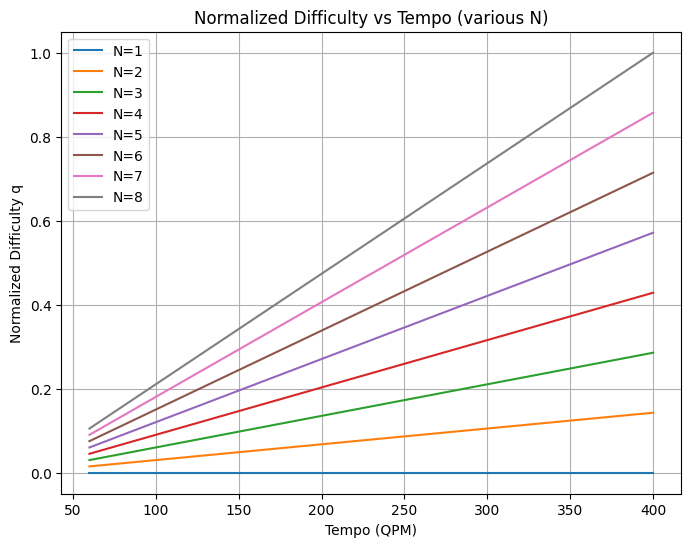

In [ ]:
# plot difficulty vs tempo for various N
import numpy as np
import matplotlib.pyplot as plt

def clip01(x: float) -> float:
    return max(0.0, min(1.0, x))    
def norm_tempo(t: int, t_min: int, t_max: int) -> float:
    return clip01((t - t_min) / (t_max - t_min))
def q_difficulty(N: int, tempo: int, N_max: int, t_min: int, t_max: int, wN: float) -> float:
    n = (N - 1) / (N_max - 1) if N_max > 1 else 0.0
    t = norm_tempo(tempo, t_min, t_max)
    return n * t

N_max = 8
tempo_min, tempo_max = 20, 400
wN = 0.9
tempos = np.linspace(60, tempo_max, 400) 
plt.figure(figsize=(8,6))
for N in [1, 2, 3, 4, 5, 6, 7, 8]:
    q_values = [q_difficulty(N, tempo, N_max, tempo_min, tempo_max, wN) for tempo in tempos]
    plt.plot(tempos, q_values, label=f"N={N}")
plt.title("Normalized Difficulty vs Tempo (various N)")
plt.xlabel("Tempo (QPM)")
plt.ylabel("Normalized Difficulty q")
plt.legend()
plt.grid(True)  
plt.show()

# difficulty vs N for tempo=60
import numpy as np
import matplotlib.pyplot as plt 
def clip01(x: float) -> float:
    return max(0.0, min(1.0, x))    

In [33]:
l = []
for n in range(1,5):
    if n == 1:
        l.append('N=1')
        continue
    for t in [60, 80, 100]:
        l.append(f'N={n}, t={t}')

l

['N=1',
 'N=2, t=60',
 'N=2, t=80',
 'N=2, t=100',
 'N=3, t=60',
 'N=3, t=80',
 'N=3, t=100',
 'N=4, t=60',
 'N=4, t=80',
 'N=4, t=100']